In [1]:
from sklearn.linear_model import LogisticRegression
import scipy
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import winter_r
from scipy.signal import savgol_filter

from util import smooth_data
from caldordata import fnsp, merged_gdf, cap23
import datetime
cdates = pd.DatetimeIndex(cap23.datetime)
cap23['datetime'] = cdates

from caldordata import stylesheet
plt.style.use(stylesheet)

/Users/cowherd/Documents/caldor-snow/scripts/caldordata.py:33: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  caldormeta = gpd.GeoDataFrame(caldormeta, crs = 'EPSG:4326')
Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


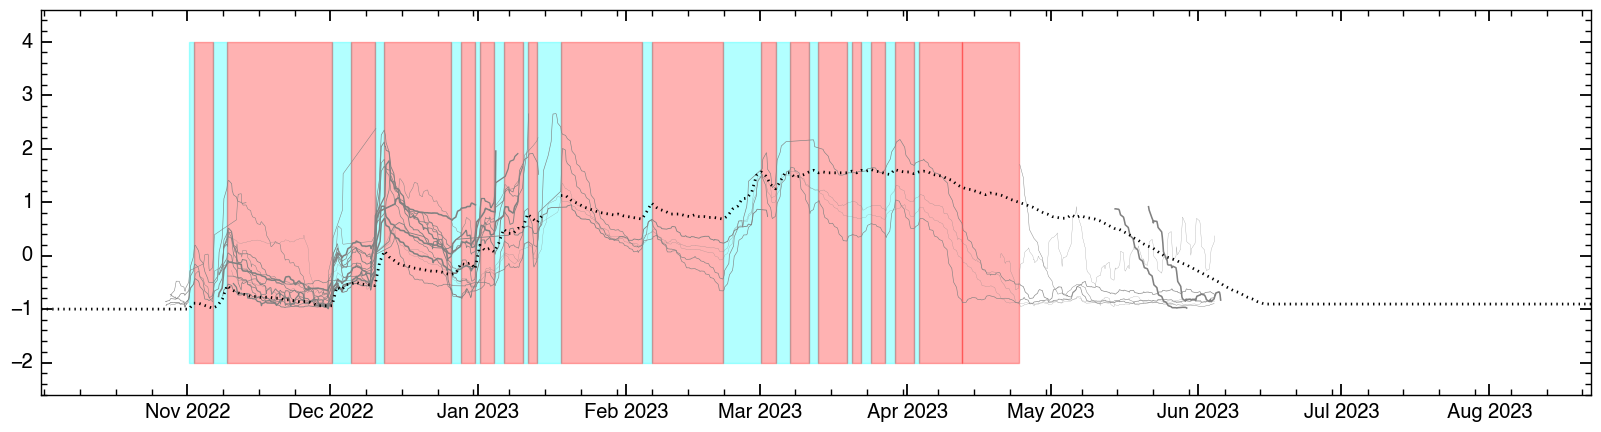

In [21]:



fig, ax = plt.subplots(figsize=(20, 5))
cmap = plt.cm.winter_r
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
norm2 = plt.Normalize(vmin=500, vmax=1000)

for fn in fnsp:
    name = fn.split('_')[2]
    if name not in skip:
        # Replace this with your actual data loading logic
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = merged_gdf[merged_gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        rdnbr = merged_gdf[merged_gdf.camera_serial == int(cam[2])].RdNBR.values[0]
        # Camera-specific adjustments
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan
            
        smoothed_norm = (smoothed - np.nanmean(smoothed) )/ np.nanmean(smoothed)
 
        ax.plot(data.index, smoothed_norm, linewidth=(norm(elev)), label=name, color = 'gray')#  cmap(norm2(rdnbr)))



ax.plot(cap23.datetime, (cap23.SNOWDEPTH - np.nanmean(cap23.SNOWDEPTH)) / np.nanmean(cap23.SNOWDEPTH), 'k:', linewidth=2, label='Caples Lake pillow')

# Define the indices
gain_indices = [
    (14786,14787), (14791, 14794), (14816, 14820), (14825, 14827), (14841, 14843), (14846, 14847), 
    (14850, 14852), (14856, 14857), (14859, 14864), (14881, 14883), (14898, 14906), (14909,14912),
    (14916, 14918), (14924,14925), (14927,14929),(14932,14934),(14938,14939)
]

# Fill between specified date ranges (gain)
for start, end in gain_indices:
    ax.fill_betweenx([-2, 4], cap23.datetime[start], cap23.datetime[end], color='cyan', alpha=0.3)

# Define yellow fill ranges
loss_indices = [
    (14787, 14791), (14794, 14816), (14820, 14825), (14827, 14841), (14843, 14846), (14847, 14850), 
    (14852, 14856), (14857, 14859), (14864, 14881), (14883, 14898), (14906, 14909), (14912, 14916),
    (14918,14924),(14925, 14927), (14929,14932),(14934,14938),(14939,14948),(14948,14960)
]

# Fill between specified yellow (loss) date ranges
for start, end in loss_indices:
    ax.fill_betweenx([-2, 4], cap23.datetime[start], cap23.datetime[end], color='red', alpha=0.3)
plt.show()


In [32]:
# Define lists to store changes in value for each line

indices_both = loss_indices + gain_indices

cap23_changes = []
smoothed_changes = {name: [] for name in fnsp}

for fn in fnsp:
    # Replace this with your actual data loading logic
    data = pd.read_csv(fn, parse_dates=True, index_col=0)
    smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
    tmp = [val.date() for val in data.index]
    smooth = pd.Series(smoothed, index=tmp)
    smooth_norm = (smooth - np.nanmean(smooth) )/ np.nanmean(smooth)
    
    # Calculate changes in value for each smoothed line within each interval
    for start, end in indices_both:
        start_date = cap23.datetime[start].date()
        end_date = cap23.datetime[end].date()
        # start_val = smooth.loc[min(smooth.index, key=lambda x: abs(x - start_date))]
    
        # end_val = smooth.loc[min(smooth.index, key=lambda x: abs(x - end_date))]
        start_indices = smooth.index[abs(smooth.index - start_date) < pd.Timedelta('1 day')]
        if len(start_indices) > 0:
            start_val = smooth.loc[min(start_indices, key=lambda x: abs(x - start_date))]
        else:
            start_val = np.nan  # or handle the case where no valid index is found

        # Filter indices within 1 day of end_date
        end_indices = smooth.index[abs(smooth.index - end_date) < pd.Timedelta('1 day')]
        if len(end_indices) > 0:
            end_val = smooth.loc[min(end_indices, key=lambda x: abs(x - end_date))]
        else:
            end_val = np.nan  # or handle the case where no valid index is found

        if type(end_val) == pd.core.series.Series:
            end_val = end_val[-1]
        if type(start_val) == pd.core.series.Series:
            start_val = start_val[0]
        smoothed_changes[fn].append(end_val- start_val)
        # print(end_val - start_val)

# Calculate changes in value for the cap23 line within each interval
for start, end in indices_both:
    start_val = cap23.SNOWDEPTH[start]
    end_val = cap23.SNOWDEPTH[end]
    cap23_changes.append((end_val - start_val)/12)



/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_36495/2425759506.py:7: RuntimeWarning: All-NaN axis encountered
  yvals = smoothed_changes[k] / np.nanmax(smoothed_changes[k])


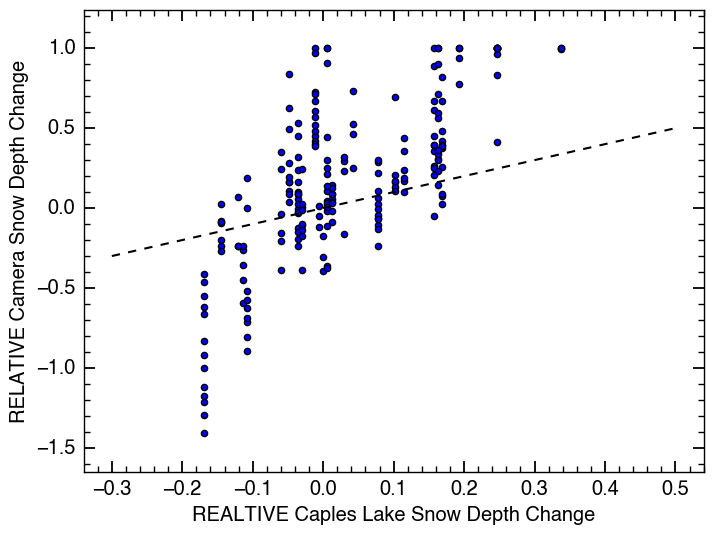

In [40]:
fig, ax = plt.subplots()
xvals = cap23_changes / (np.nanmax(cap23.SNOWDEPTH)/12)
## add color that corresponds to the burn severity ## 
xx = []
yy = []
for k in smoothed_changes.keys():
    yvals = smoothed_changes[k] / np.nanmax(smoothed_changes[k])
    ax.scatter(xvals, yvals)
    xx.append(xvals)
    yy.append(yvals)
ax.set_xlabel('REALTIVE Caples Lake Snow Depth Change')
ax.set_ylabel('RELATIVE Camera Snow Depth Change')
ax.plot([-.3, .5], [-.3, .5], 'k--')
plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_36495/3443043655.py:11: RuntimeWarning: All-NaN axis encountered
  yvals = smoothed_changes[k] / np.nanmax(smoothed_changes[k])


Coefficients of regression line: [3.00762808 0.0726013 ]
R2 score: 0.513406974757
Range of x values: -0.16867469879518074 0.3373493975903615


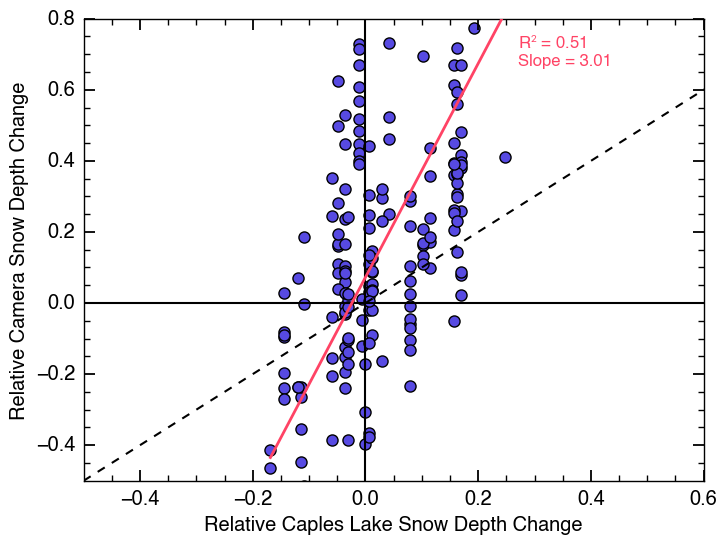

In [102]:
from sklearn.metrics import r2_score
c1 = '#FF4365'
# c1= '#A23B72'
c2 = '#574AE2'
fig, ax = plt.subplots()
xvals = cap23_changes / (np.nanmax(cap23.SNOWDEPTH)/12)

xx = []
yy = []
for k in smoothed_changes.keys():
    yvals = smoothed_changes[k] / np.nanmax(smoothed_changes[k])
    # ax.scatter(xvals, yvals)
    xx.append(xvals)
    yy.append(yvals)

# Flatten the lists of x and y values
xx_flat = np.concatenate(xx)
yy_flat = np.concatenate(yy)
nanmask = np.logical_and(np.isfinite(xx_flat), np.isfinite(yy_flat))
xx_flat = xx_flat[nanmask]
yy_flat = yy_flat[nanmask]

# Calculate the regression line
z = np.polyfit(xx_flat, yy_flat, 1)
p = np.poly1d(z)
print("Coefficients of regression line:", z)
yp_pred = p(xx_flat)
r2 = r2_score(yy_flat, yp_pred)
print("R2 score:", r2)



# Plot the regression line
xp = np.linspace(xx_flat.min(), xx_flat.max(), 100)
print("Range of x values:", xx_flat.min(), xx_flat.max())
ax.plot(xx_flat, yy_flat,'o', color = c2)
ax.plot(xp, p(xp), color = c1, linewidth=2, zorder=10)
ax.set_xlabel('Relative Caples Lake Snow Depth Change')
ax.set_ylabel('Relative Camera Snow Depth Change')

# add lines
ax.plot([-.8, .8], [-.8, .8], 'k--')
ax.plot([0,0], [-1,1], 'k')
ax.plot([-1,1], [0,0],'k')
ax.set_xlim((-0.5, 0.6))
ax.set_ylim((-0.5, 0.8))  
ax.text(0.7, 0.9, r'R$^2$'+ f' = {r2:.2f}\nSlope = {z[0]:.2f}', fontsize=12, color = c1, transform = ax.transAxes)
plt.show()

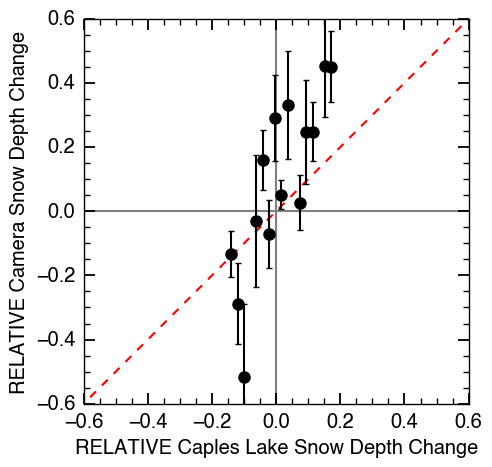

In [65]:
ct = 26
len(yy)
ayy = np.array(yy)
ayy.shape
tmp = []
ymean = []
ystd = []
for i in range(ayy.shape[1]):
    data = ayy[:,i]
    data = data[~np.isnan(data)]
    tmp.append(data)
    ymean.append(np.nanmean(data))
    ystd.append(np.nanstd(data))
ayy = np.array(yy)
axx = np.array(xx)
import scikits.bootstrap as boot
lx = axx.flatten()
ly = ayy.flatten()

from sklearn.linear_model import LinearRegression
import scipy
ymean, edges, bnum = scipy.stats.binned_statistic(lx[~np.isnan(ly)], ly[~np.isnan(ly)], 'mean', bins=ct)
ystd, e, bn = scipy.stats.binned_statistic(lx[~np.isnan(ly)], ly[~np.isnan(ly)], 'std', bins=ct)
mids = (edges[:-1]+edges[1:])/2

ci = np.zeros_like(mids)
for ii in range(len(ci)):
    ci[ii] = 1.96*ystd[ii] /np.sqrt(np.sum(bnum == (ii+1)))
fig,ax = plt.subplots(figsize = (5,5))
#ax.scatter(lx,ly, alpha = 0.2, color = 'blue')
# ax.set_ylim((-3,5.5))
# ax.set_xlim((-3,5.5))
ax.plot([-1, 1], [-1, 1], 'r--')
ax.plot([0,0], [-1,1], 'gray')
ax.plot([-1,1], [0,0],'gray')
ax.errorbar(mids, ymean, yerr=ci,fmt = 'o', capsize=2) #label=(r'$C_1$ = '+ str(round(model.coef_[0][0], 2)) + r' $\pm$ ' + str(round(c1error, 2))))
ax.set_aspect('equal')
ax.set_xlabel('RELATIVE Caples Lake Snow Depth Change')
ax.set_ylabel('RELATIVE Camera Snow Depth Change')
ax.set_xlim((-0.6, 0.6))
ax.set_ylim((-0.6, 0.6))  
plt.show()

In [29]:
fig, ax = plt.subplots()
xvals = cap23_changes
## add color that corresponds to the burn severity ## 
xx = []
yy = []
for k in smoothed_changes.keys():
    yvals = smoothed_changes[k]
    ax.scatter(xvals, yvals)
    xx.append(xvals)
    yy.append(yvals)
ax.set_xlabel('Caples Lake Snow Depth Change')
ax.set_ylabel('Camera Snow Depth Change')
ax.plot([-3, 5], [-3, 5], 'k--')
plt.show()

35

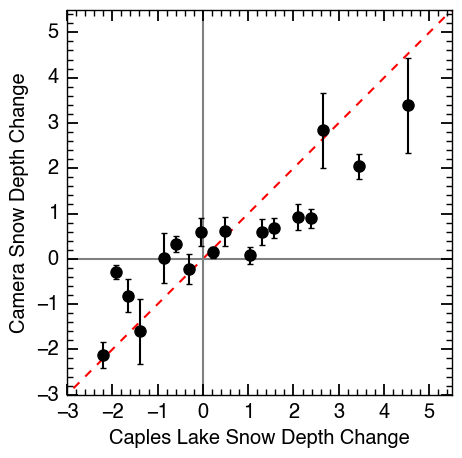

In [31]:
ct = 26
len(yy)
ayy = np.array(yy)
ayy.shape
tmp = []
ymean = []
ystd = []
for i in range(ayy.shape[1]):
    data = ayy[:,i]
    data = data[~np.isnan(data)]
    tmp.append(data)
    ymean.append(np.nanmean(data))
    ystd.append(np.nanstd(data))
ayy = np.array(yy)
axx = np.array(xx)
import scikits.bootstrap as boot
lx = axx.flatten()
ly = ayy.flatten()

from sklearn.linear_model import LinearRegression
import scipy
ymean, edges, bnum = scipy.stats.binned_statistic(lx[~np.isnan(ly)], ly[~np.isnan(ly)], 'mean', bins=ct)
ystd, e, bn = scipy.stats.binned_statistic(lx[~np.isnan(ly)], ly[~np.isnan(ly)], 'std', bins=ct)
mids = (edges[:-1]+edges[1:])/2

ci = np.zeros_like(mids)
for ii in range(len(ci)):
    ci[ii] = 1.96*ystd[ii] /np.sqrt(np.sum(bnum == (ii+1)))
fig,ax = plt.subplots(figsize = (5,5))
#ax.scatter(lx,ly, alpha = 0.2, color = 'blue')
ax.set_ylim((-3,5.5))
ax.set_xlim((-3,5.5))
ax.plot([-5, 6], [-5, 6], 'r--')
ax.plot([0,0], [-10,10], 'gray')
ax.plot([-10,10], [0,0],'gray')
ax.errorbar(mids, ymean, yerr=ci,fmt = 'o', capsize=2) #label=(r'$C_1$ = '+ str(round(model.coef_[0][0], 2)) + r' $\pm$ ' + str(round(c1error, 2))))
ax.set_aspect('equal')
ax.set_xlabel('Caples Lake Snow Depth Change')
ax.set_ylabel('Camera Snow Depth Change')
plt.show()

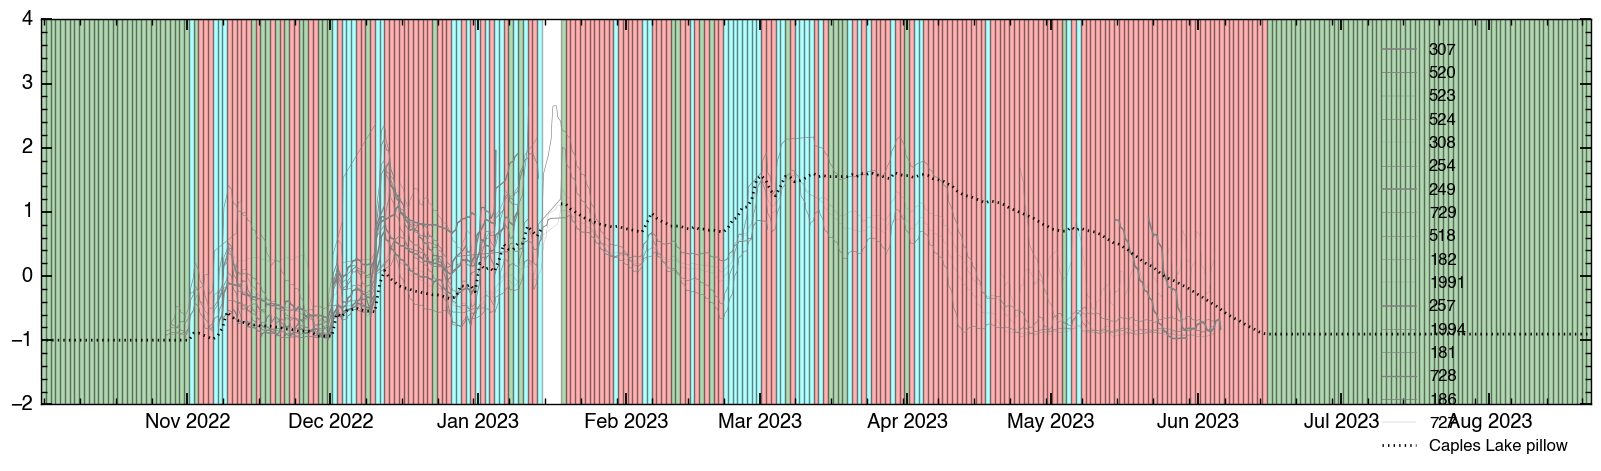

In [318]:
fig, ax = plt.subplots(figsize=(20, 5))
cmap = plt.cm.winter_r
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
norm2 = plt.Normalize(vmin=500, vmax=1000)
cap232 = cap23.copy().reset_index()
my_daily_diffs = []
for fn in fnsp:
    name = fn.split('_')[2]
    if name not in skip:
        # Replace this with your actual data loading logic
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = merged_gdf[merged_gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        rdnbr = merged_gdf[merged_gdf.camera_serial == int(cam[2])].RdNBR.values[0]
        # Camera-specific adjustments
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan
            
        smoothed_norm = (smoothed - np.nanmean(smoothed)) / np.nanmean(smoothed)
        mydiff = pd.Series(data = smoothed_norm, index = data.index).diff()
        my_daily_diffs.append(mydiff)
        
 
        ax.plot(data.index, smoothed_norm, linewidth=(norm(elev)), label=name, color='gray')

# Plot Caples Lake pillow data
ax.plot(cap232.datetime, (cap232.SNOWDEPTH - np.nanmean(cap232.SNOWDEPTH)) / np.nanmean(cap232.SNOWDEPTH), 'k:', linewidth=2, label='Caples Lake pillow')

# Calculate daily changes
capdiff = pd.Series(data = cap232.SNOWDEPTH.diff().values, index = cap232.datetime)



# Color the background based on daily changes
for i in range(len(cap232) - 1):
    if capdiff[i+1] > 0:
        ax.axvspan(cap232.datetime[i], cap232.datetime[i+1], facecolor='cyan', alpha=0.3)
    elif capdiff[i+1] < 0:
        ax.axvspan(cap232.datetime[i], cap232.datetime[i+1], facecolor='red', alpha=0.3)
    elif capdiff[i+1] == 0:
        ax.axvspan(cap232.datetime[i], cap232.datetime[i+1], facecolor='green', alpha=0.3)

ax.set_ylim(-2, 4)
ax.legend()
plt.show()

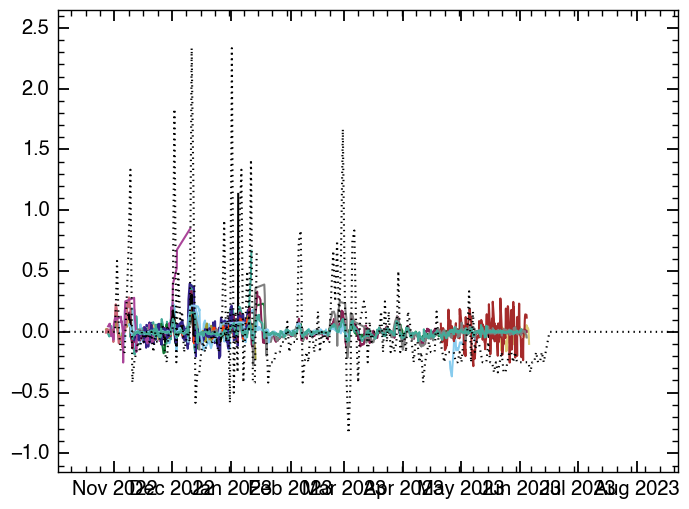

In [261]:
fig, ax = plt.subplots()
for diffs in my_daily_diffs:
    ax.plot(diffs)
ax.plot(capdiff/12, 'k:')
plt.show()

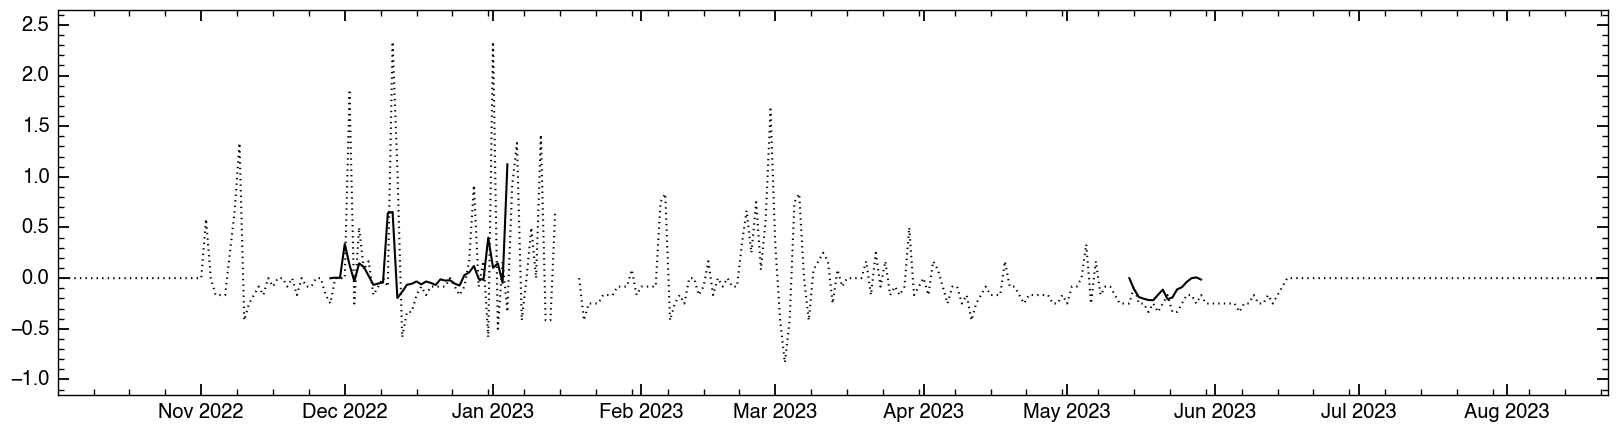

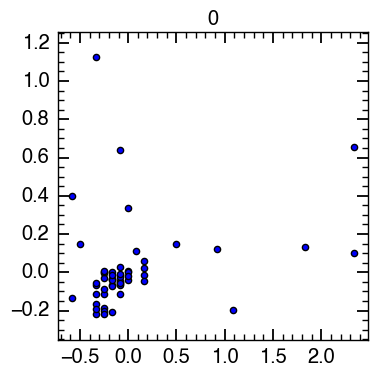

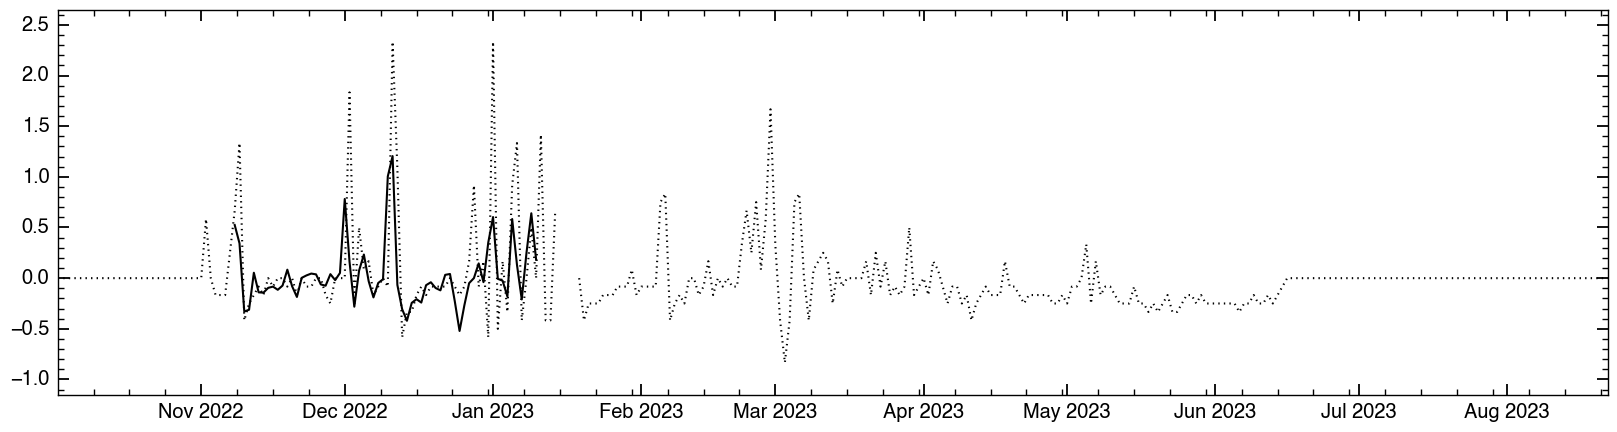

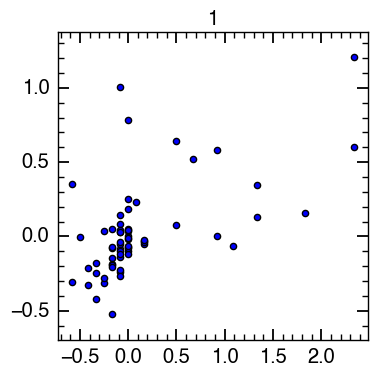

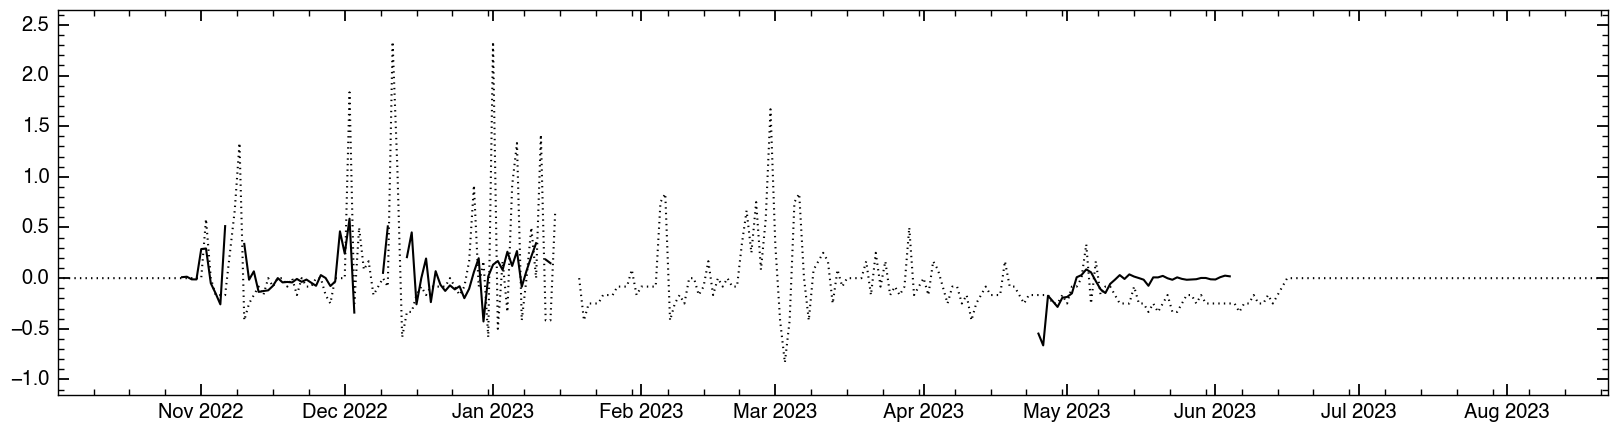

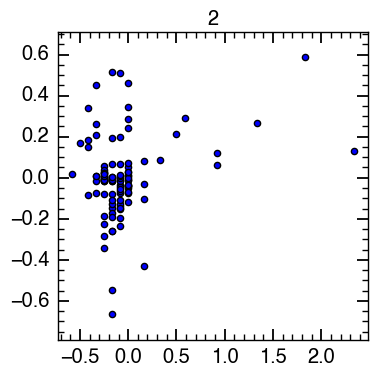

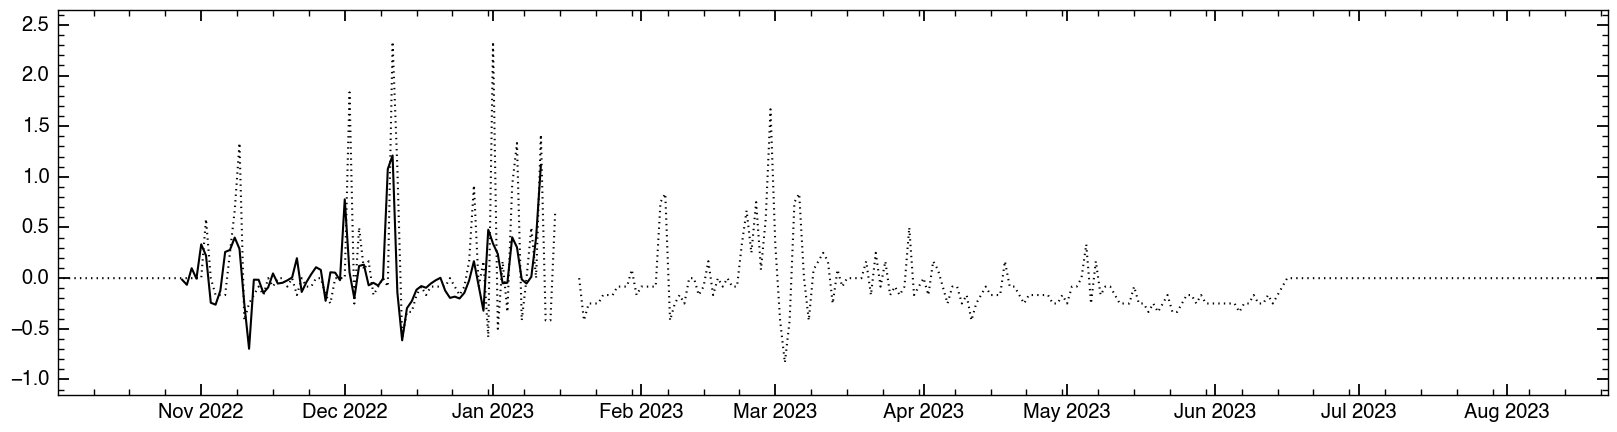

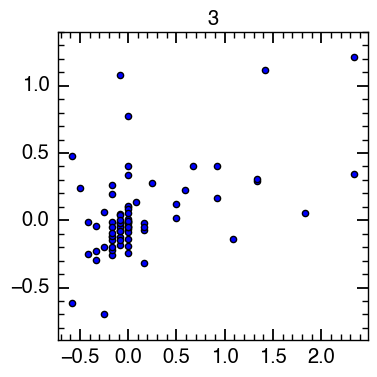

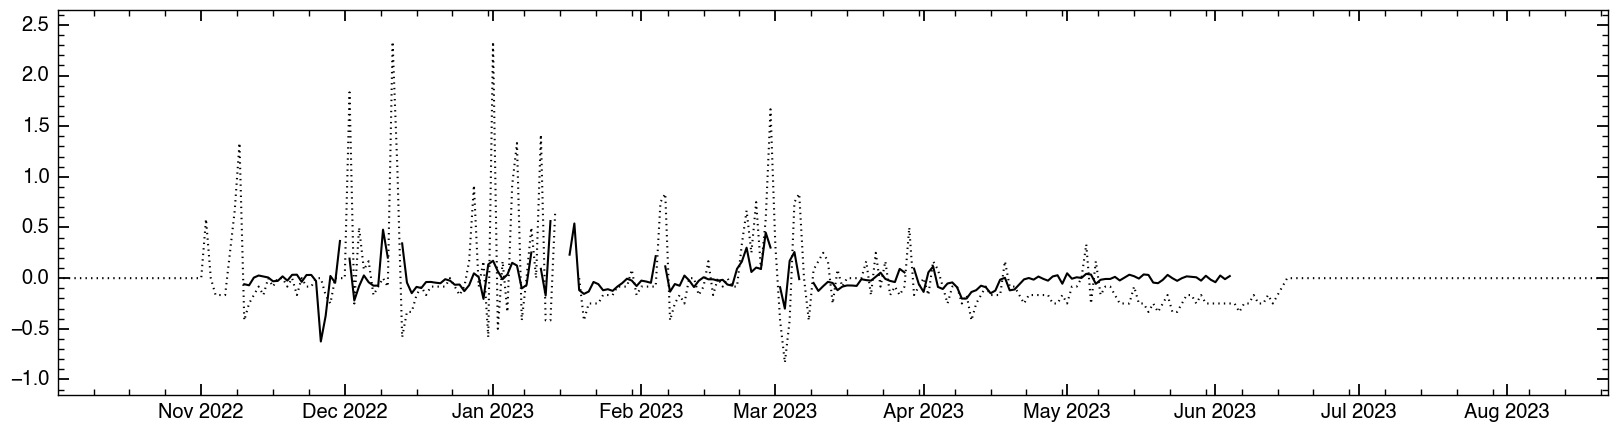

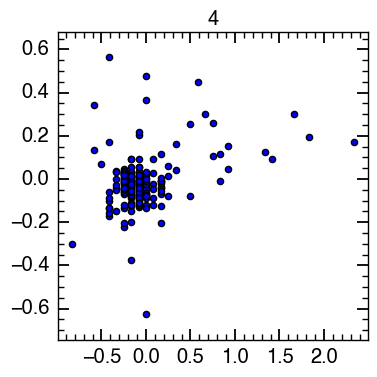

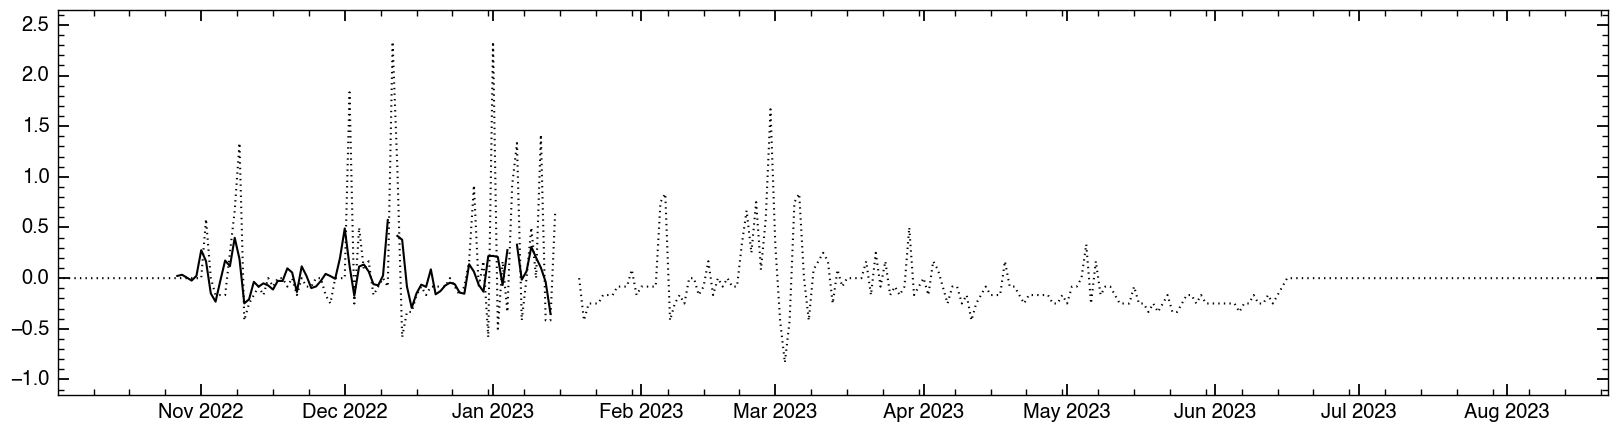

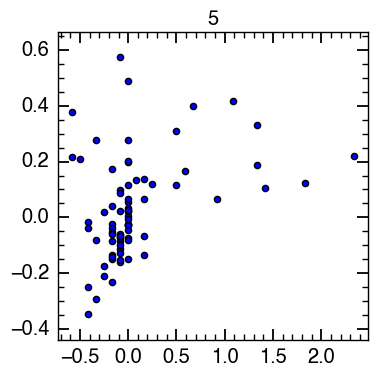

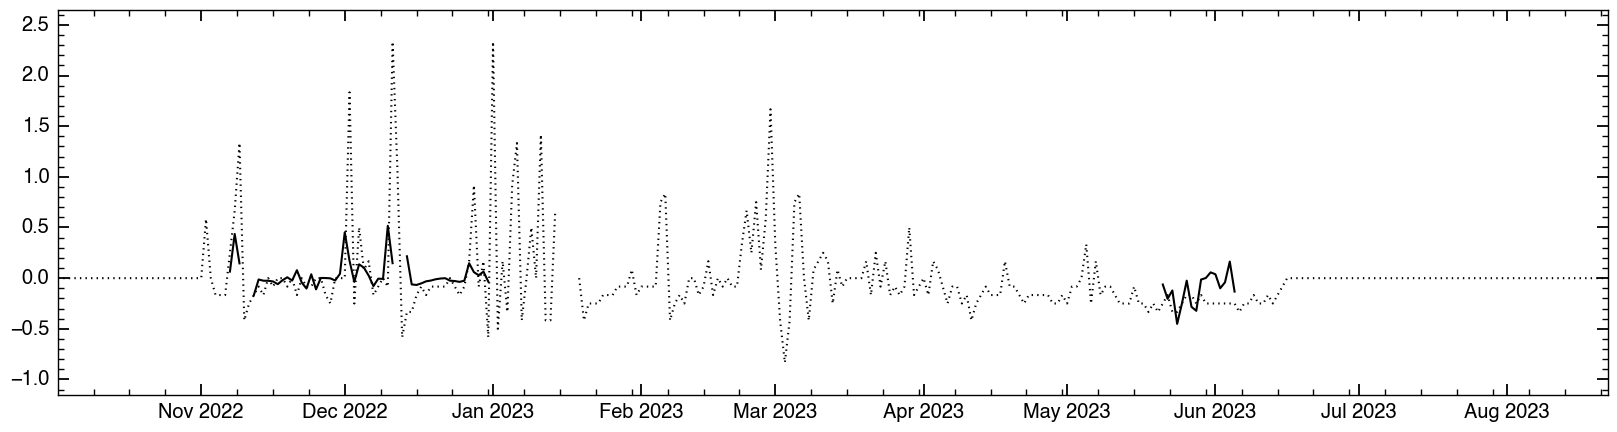

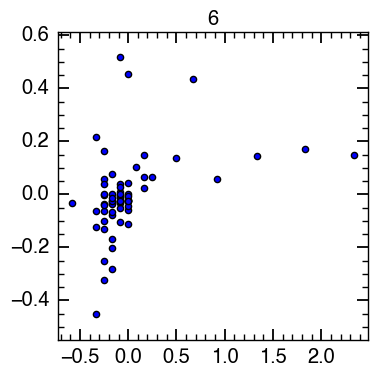

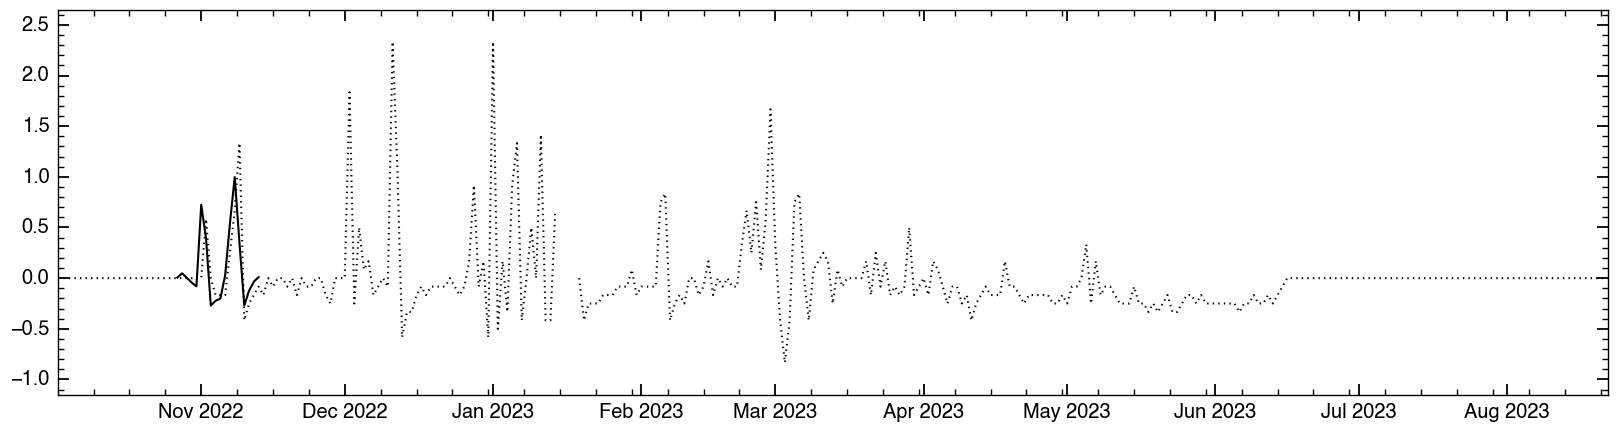

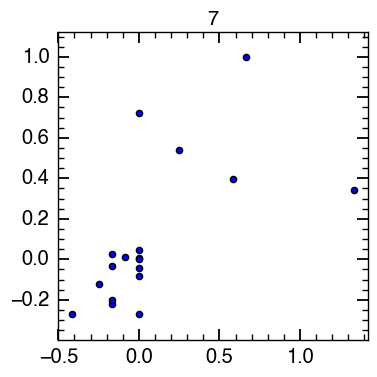

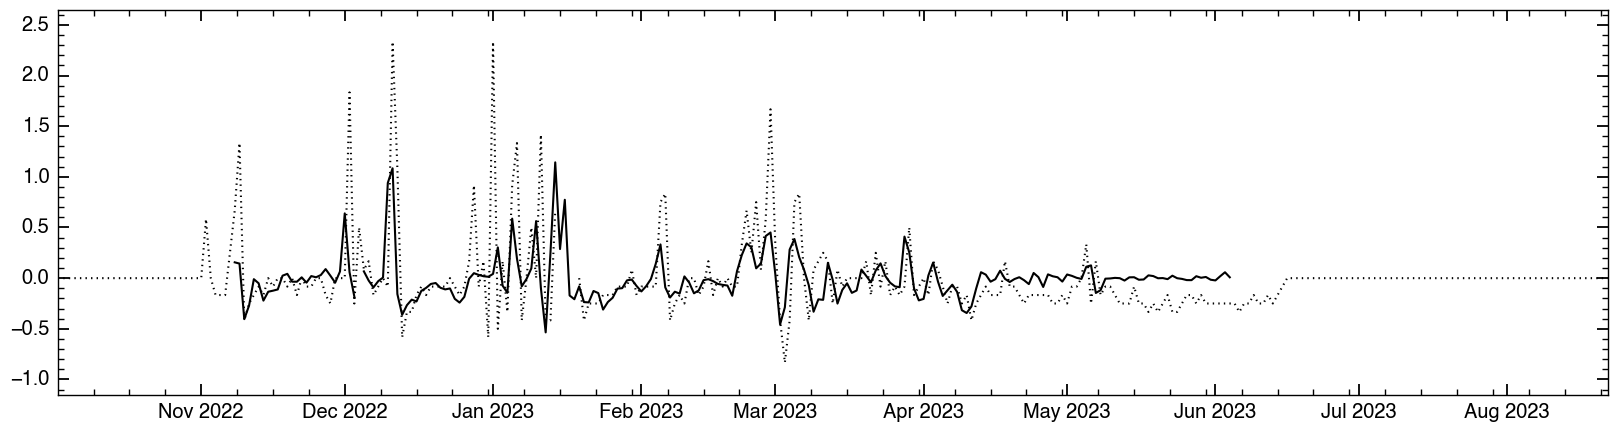

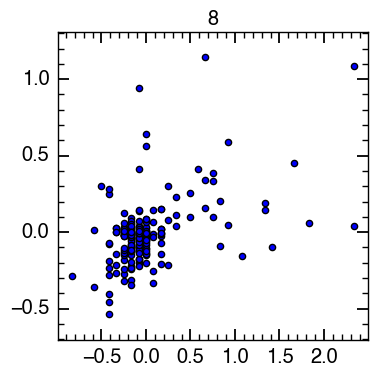

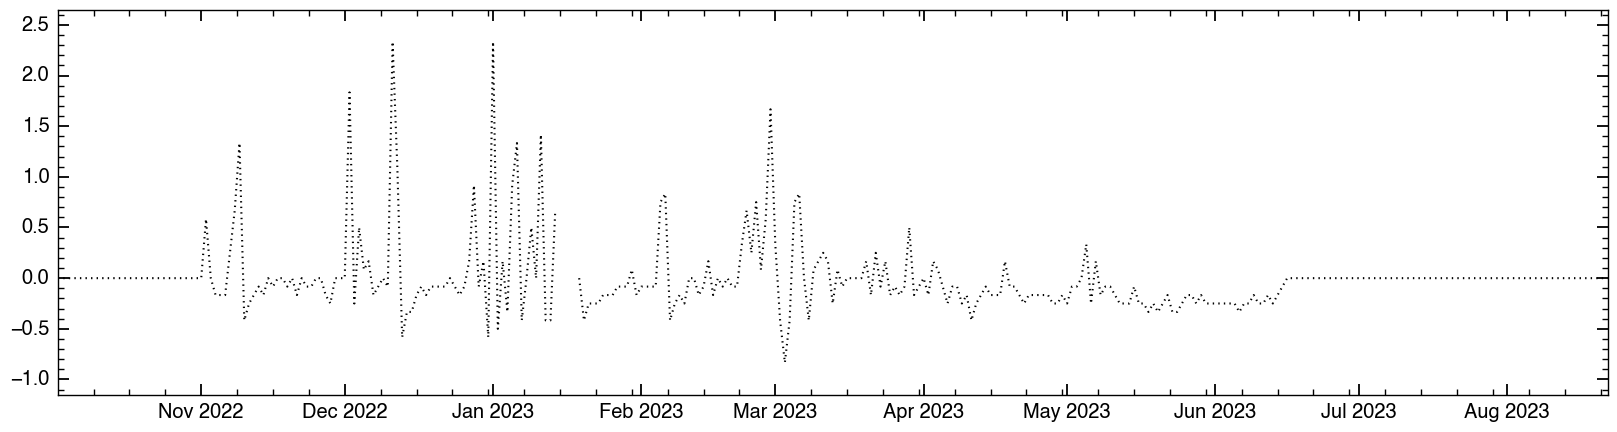

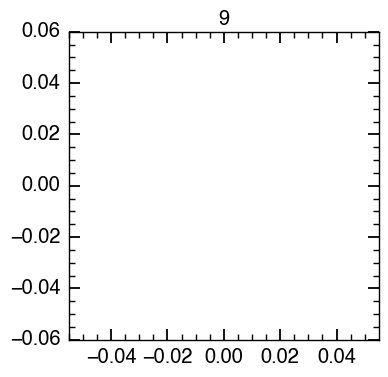

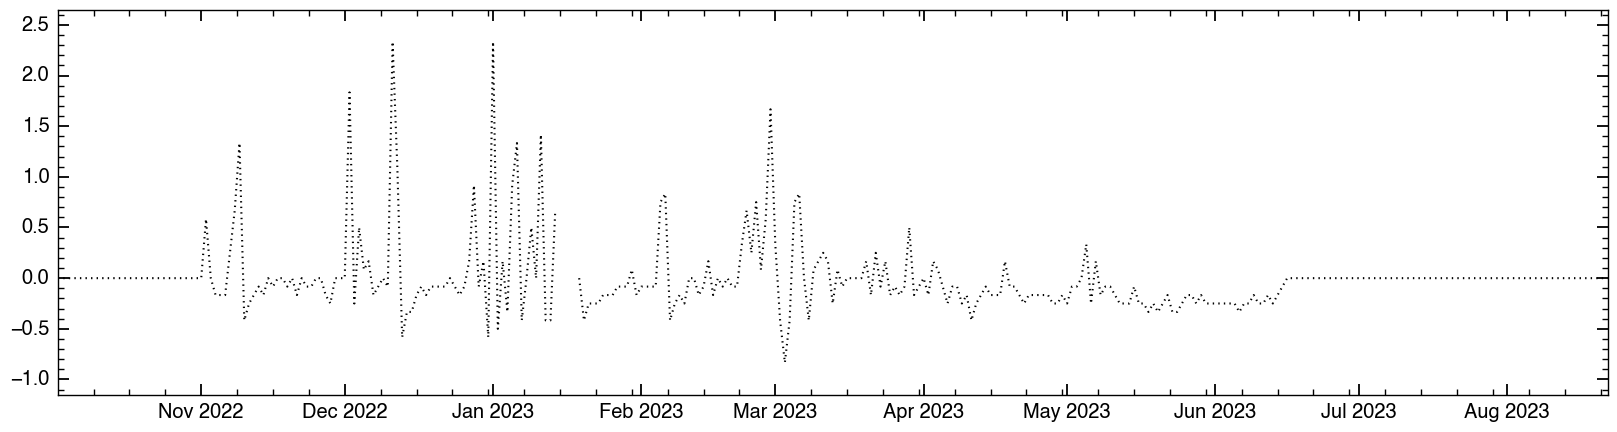

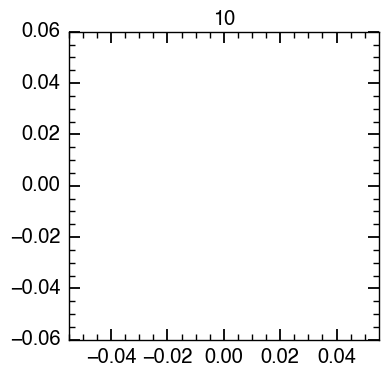

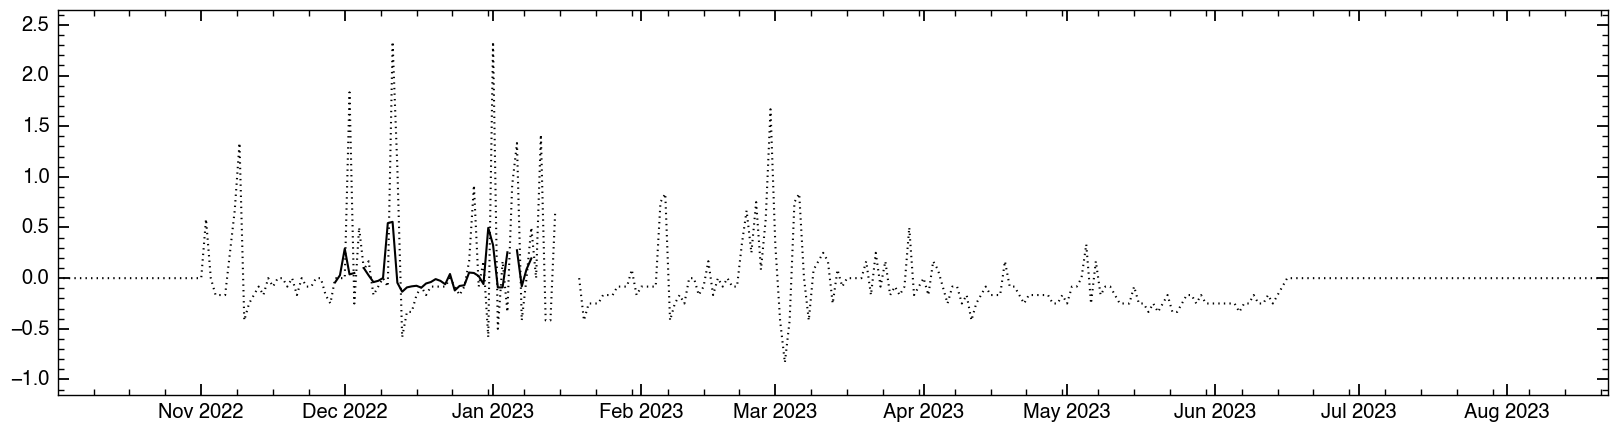

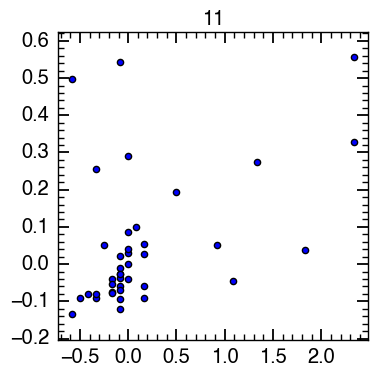

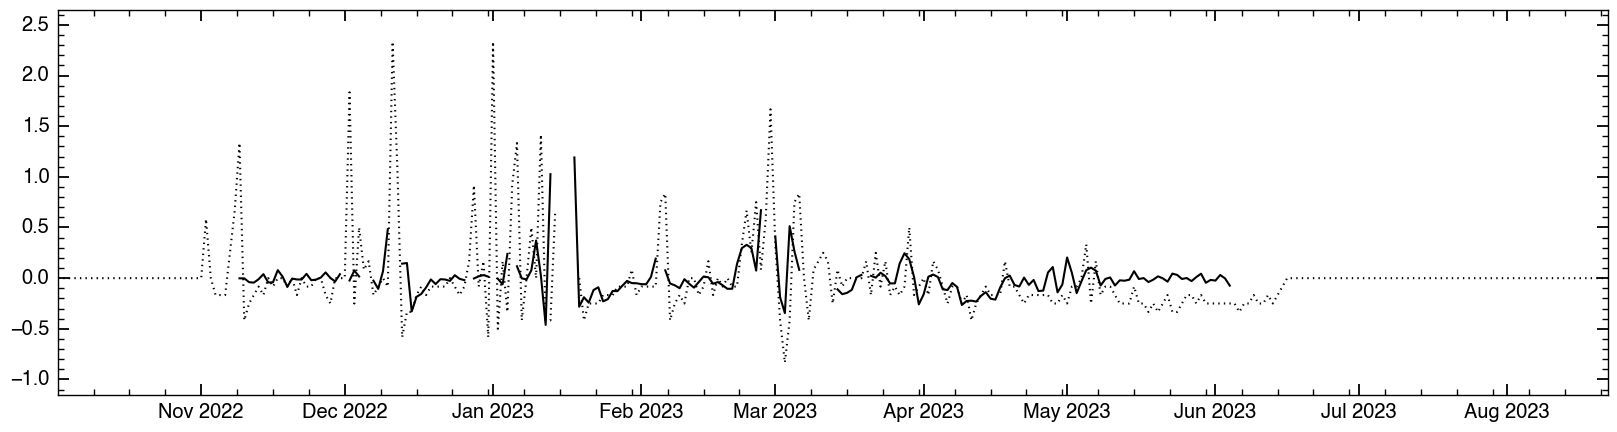

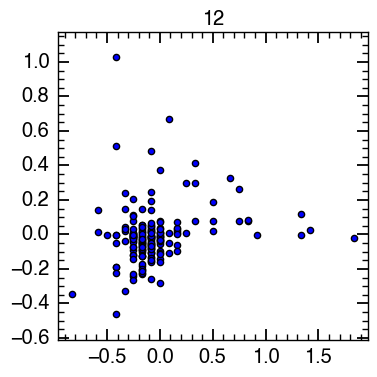

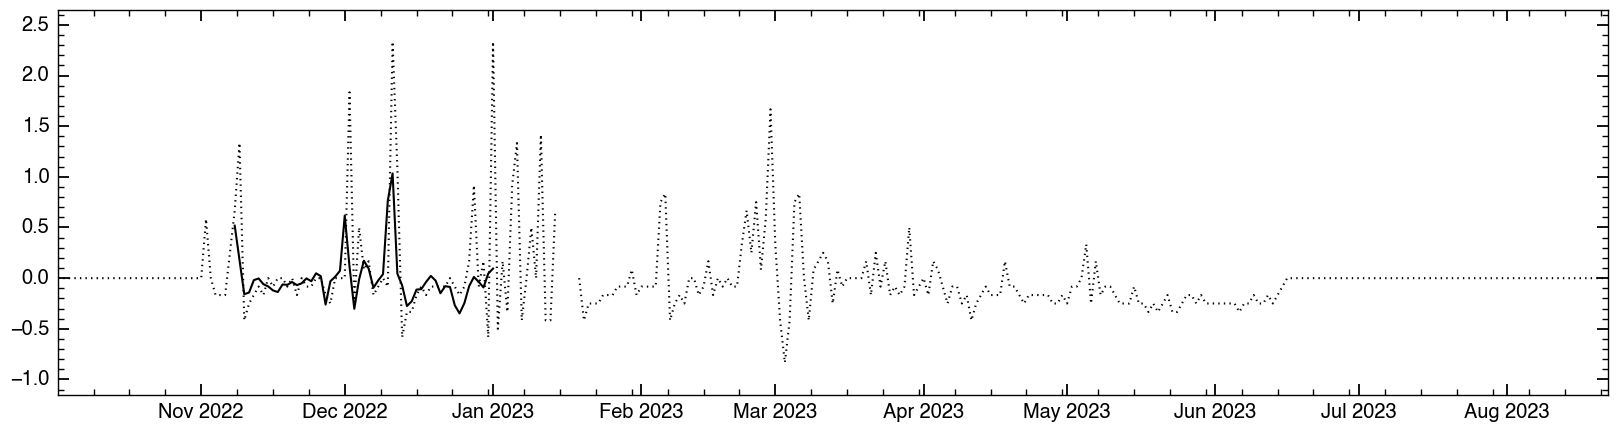

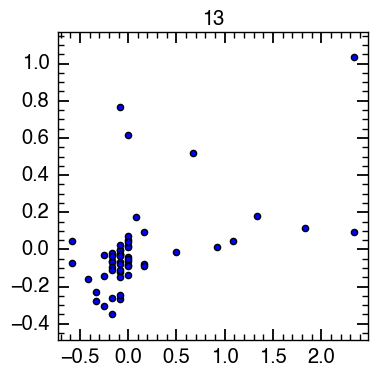

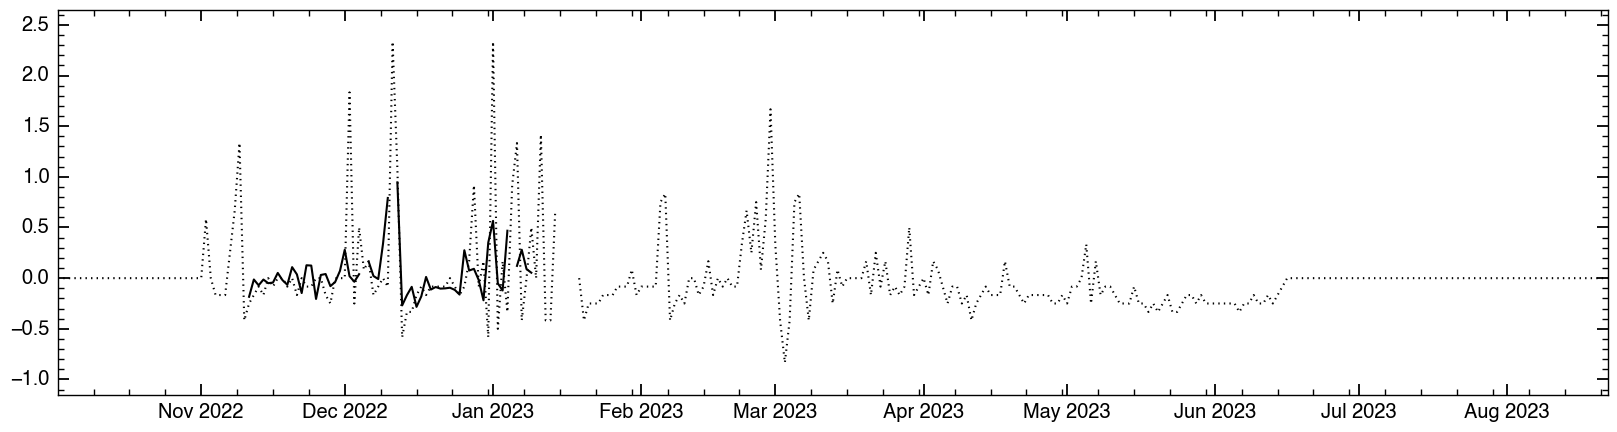

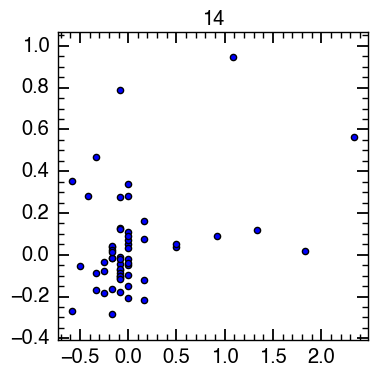

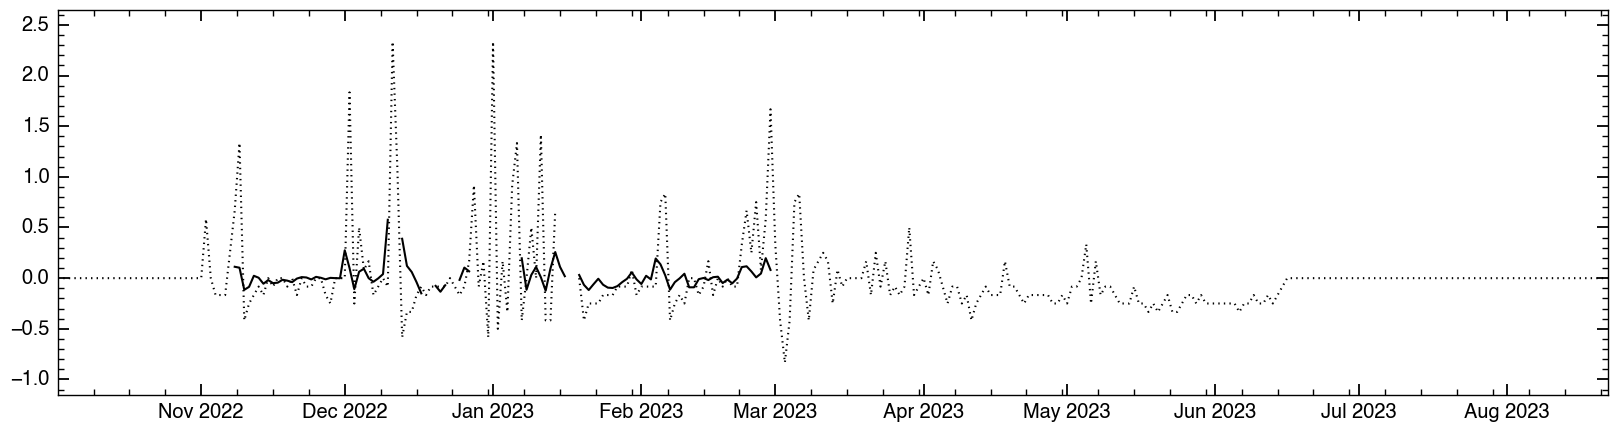

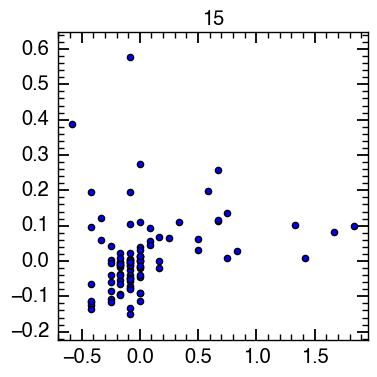

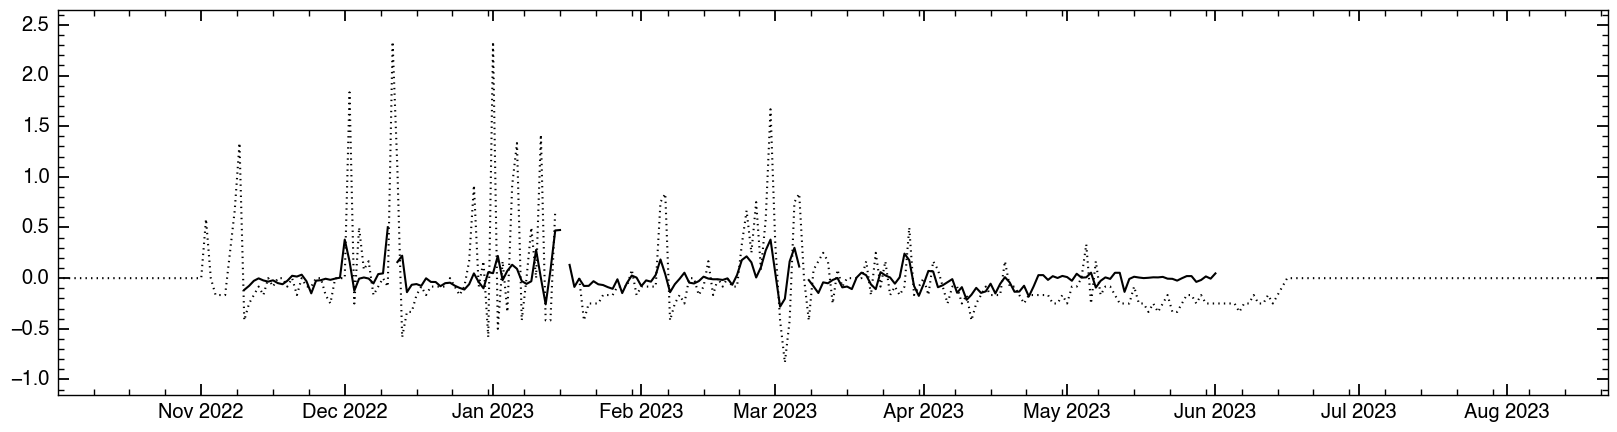

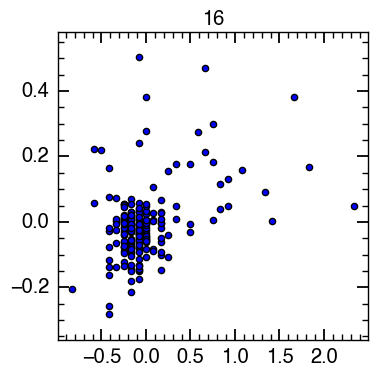

In [302]:
al_diffs = []
for i,diffs in enumerate(my_daily_diffs):
    fig, ax = plt.subplots(figsize=(20, 5))
    aligned_diff = []
    for target_date in capdiff.index.date:
        if i in [9,10]:
            aligned_diff.append(np.nan)
        else:
            tmpdata = diffs[diffs.index.date == target_date]
            if len(tmpdata.values[~np.isnan(tmpdata.values)]) > 0:
                aligned_diff.append(np.nansum(tmpdata.values))
            else:
                aligned_diff.append(np.nan)
    ax.plot(capdiff.index.date, aligned_diff)
    al_diffs.append(aligned_diff)
    ax.plot(capdiff.index.date, capdiff.values/12, 'k:')    
    plt.show()
    fig, ax = plt.subplots(figsize = (4,4))
    ax.scatter(capdiff.values/12, aligned_diff)
    ax.set_title(i)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


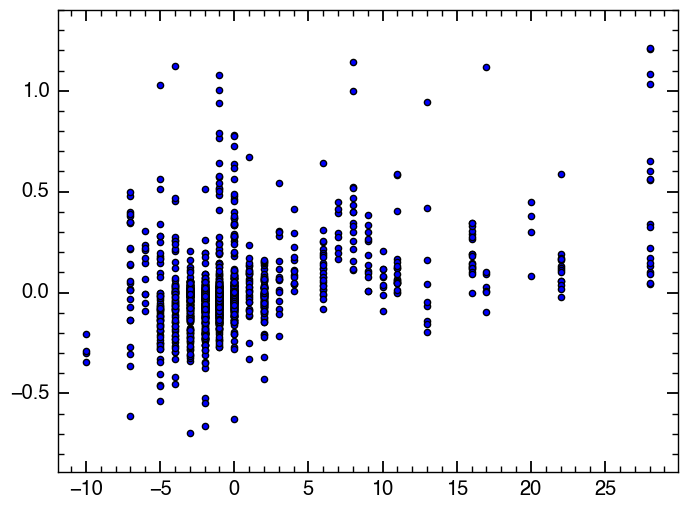

In [305]:
colors = ['red', 'darkgreen', 'cyan','sienna','blue', 
          'green', 'orange', 'purple','pink','brown',
          'black','yellow','cyan','magenta','gray', 
          'red', 'red']
fig, ax = plt.subplots()
for i,diffs in enumerate(al_diffs):
    ax.scatter(capdiff, diffs) #, label = i)# , c = colors[i])
ax.legend()
plt.show()

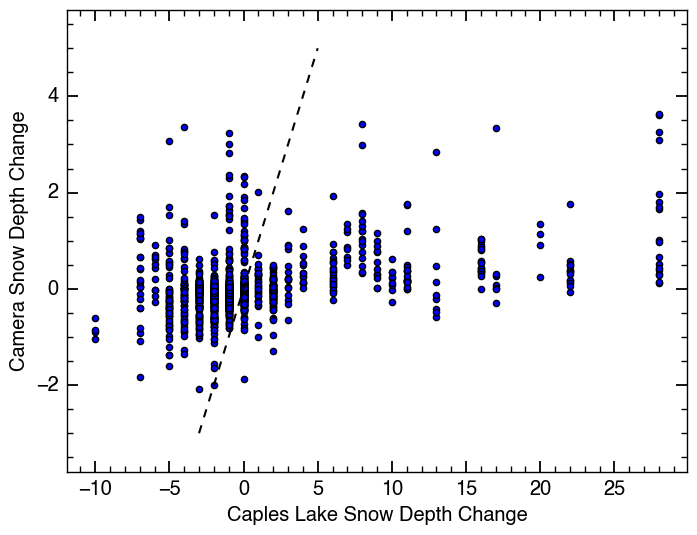

In [317]:
fig, ax = plt.subplots()
xvals = capdiff
## add color that corresponds to the burn severity ## 
xx = []
yy = []
for yvals in al_diffs:
#     ax.scatter(xvals, yvals)
    xx.append(xvals)
    yy.append(yvals)
ax.scatter(np.array(xx).flatten(), np.array(yy).flatten() * 3) 
ax.set_xlabel('Caples Lake Snow Depth Change')
ax.set_ylabel('Camera Snow Depth Change')
ax.plot([-3, 5], [-3, 5], 'k--')
# ax.set_xlim((-3, 5))    
# ax.set_ylim((-3, 5))
plt.show()

In [285]:
len(yy)
ayy = np.array(yy)
ayy.shape
tmp = []
ymean = []
ystd = []
for i in range(0, 20):
    data = ayy[:,i]
    data = data[~np.isnan(data)]
    tmp.append(data)
    ymean.append(np.nanmean(data))
    ystd.append(np.nanstd(data))
ayy = np.array(yy)
axx = np.array(xx)
import scikits.bootstrap as boot
lx = axx.flatten()
ly = ayy.flatten()


/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_11766/3400273404.py:11: RuntimeWarning: Mean of empty slice
  ymean.append(np.nanmean(data))
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


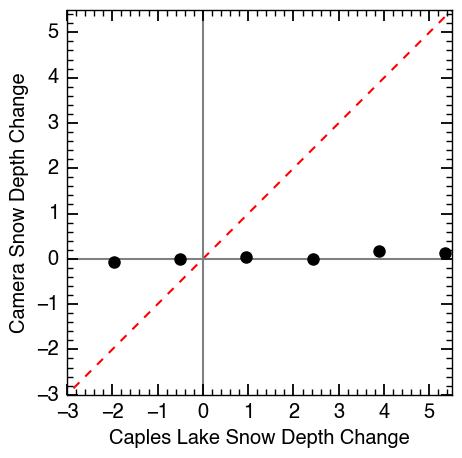

In [295]:
ct = 26
from sklearn.linear_model import LinearRegression
import scipy
ymean, edges, bnum = scipy.stats.binned_statistic(lx[(~np.isnan(ly)) & (~np.isnan(lx))],
                                                  ly[(~np.isnan(ly)) & (~np.isnan(lx))], 'mean',
                                                  bins=ct)
ystd, e, bn = scipy.stats.binned_statistic(lx[(~np.isnan(ly)) & (~np.isnan(lx))],
                                                  ly[(~np.isnan(ly)) & (~np.isnan(lx))], 'std', bins=ct)
mids = (edges[:-1]+edges[1:])/2

ci = np.zeros_like(mids)
for ii in range(len(ci)):
    ci[ii] = 1.96*ystd[ii] /np.sqrt(np.sum(bnum == (ii+1)))
fig,ax = plt.subplots(figsize = (5,5))
#ax.scatter(lx,ly, alpha = 0.2, color = 'blue')
ax.set_ylim((-3,5.5))
ax.set_xlim((-3,5.5))
ax.plot([-5, 6], [-5, 6], 'r--')
ax.plot([0,0], [-10,10], 'gray')
ax.plot([-10,10], [0,0],'gray')
ax.errorbar(mids, ymean, yerr=ci,fmt = 'o', capsize=2) #label=(r'$C_1$ = '+ str(round(model.coef_[0][0], 2)) + r' $\pm$ ' + str(round(c1error, 2))))
ax.set_aspect('equal')
ax.set_xlabel('Caples Lake Snow Depth Change')
ax.set_ylabel('Camera Snow Depth Change')
plt.show()

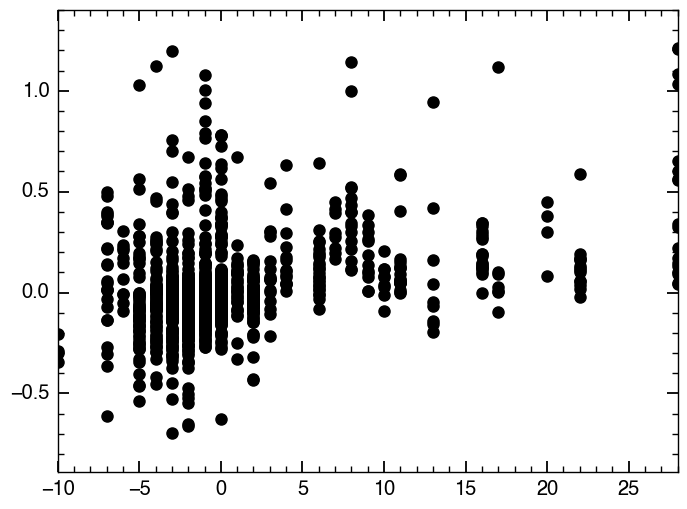

In [296]:
plt.plot(lx[(~np.isnan(ly)) & (~np.isnan(lx))], ly[(~np.isnan(ly)) & (~np.isnan(lx))], 'o')